<a href="https://colab.research.google.com/github/Ashkabsha/TimeSeries/blob/main/RNN_PRO_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Packages

In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
import yfinance as yf
from keras.initializers import RandomNormal

In [58]:


stock_symbol = 'TSLA'
df = yf.download(stock_symbol,period="60mo",interval="1d")
print(df.head())

[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-11-28  23.066000  23.218666  22.813999  23.191334  23.191334   61914000
2018-11-29  23.133333  23.166668  22.636667  22.744667  22.744667   46210500
2018-11-30  22.788668  23.440001  22.550667  23.365334  23.365334   84436500
2018-12-03  24.000000  24.400000  23.466667  23.899332  23.899332  124597500
2018-12-04  23.736668  24.578667  23.466667  23.980000  23.980000  126928500


Importing Data

In [59]:
df.index = df.index.strftime('%Y-%m-%d')

In [60]:
df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-28,23.066000,23.218666,22.813999,23.191334,23.191334,61914000
2018-11-29,23.133333,23.166668,22.636667,22.744667,22.744667,46210500
2018-11-30,22.788668,23.440001,22.550667,23.365334,23.365334,84436500
2018-12-03,24.000000,24.400000,23.466667,23.899332,23.899332,124597500
2018-12-04,23.736668,24.578667,23.466667,23.980000,23.980000,126928500
...,...,...,...,...,...,...
2023-11-20,234.039993,237.100006,231.020004,235.600006,235.600006,116320100
2023-11-21,235.039993,243.619995,233.339996,241.199997,241.199997,122288000
2023-11-22,242.039993,244.009995,231.399994,234.210007,234.210007,117950600


In [61]:
len(df)

1257

<Axes: xlabel='Date'>

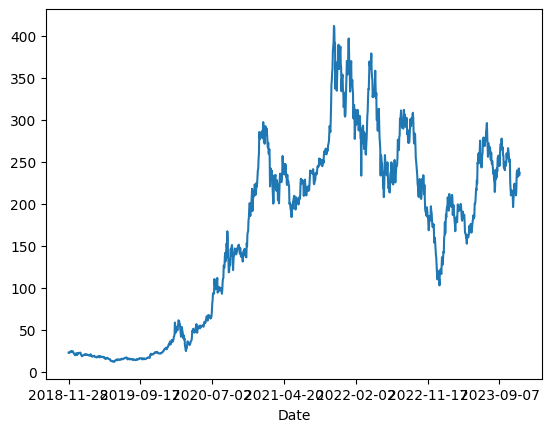

In [62]:
df['Open'].plot()

In [63]:
b_size=32
epoch=200
train_per=0.8
w_size=30
f_size=10

In [64]:
t_size=int(len(df)*train_per)

Train-Test Split

Normalization

In [65]:
sc = MinMaxScaler(feature_range = (0, 1))


Create target values

In [66]:
data_train = df.iloc[:t_size, 1:2].values
data_test = df.iloc[t_size:, 1:2].values
data_total = df.iloc[:,1:2]#open price
sc = MinMaxScaler(feature_range = (0, 1))
training_scaled = sc.fit_transform(data_train)

#Train Data
x_train = []
y_train = []
for iter in range(w_size, t_size):
    x_train.append(training_scaled[iter-w_size:iter, 0])
    y_train.append(training_scaled[iter, 0])
x_train, y_train=np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


#Test data
total_input = data_total[len(data_total) - len(data_test) - w_size:].values
total_input = total_input.reshape(-1, 1)
total_input = sc.transform(total_input)
x_test = []
y_test=[]

# Calculate the maximum number of blocks of length w_size that can be created
blocks = len(total_input) - w_size

for iter in range(blocks):
    x_test.append(total_input[iter:iter+w_size, 0])
    y_test.append(total_input[iter+w_size, 0])     #new addition

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


Defining Model

In [67]:
initializer = RandomNormal(mean=0.0, stddev=0.05)
algo = Sequential()
algo.add(SimpleRNN(units=60, return_sequences=True, input_shape=(x_train.shape[1], 1), kernel_initializer=initializer))
algo.add(Dropout(0.2))
algo.add(SimpleRNN(units=60))

algo.add(Dense(units=1))
algo.compile(optimizer = 'adam', loss = 'mean_squared_error')
print(algo.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 30, 60)            3720      
                                                                 
 dropout_4 (Dropout)         (None, 30, 60)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 60)                7260      
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 11041 (43.13 KB)
Trainable params: 11041 (43.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Training Model

In [68]:
algo.fit(x_train, y_train, epochs = epoch, batch_size = b_size, validation_split=0.15,verbose=2)

Epoch 1/200
26/26 - 4s - loss: 0.0234 - val_loss: 0.0140 - 4s/epoch - 158ms/step
Epoch 2/200
26/26 - 1s - loss: 0.0055 - val_loss: 0.0062 - 1s/epoch - 43ms/step
Epoch 3/200
26/26 - 1s - loss: 0.0033 - val_loss: 0.0034 - 1s/epoch - 43ms/step
Epoch 4/200
26/26 - 1s - loss: 0.0028 - val_loss: 0.0024 - 1s/epoch - 40ms/step
Epoch 5/200
26/26 - 1s - loss: 0.0027 - val_loss: 0.0072 - 1s/epoch - 40ms/step
Epoch 6/200
26/26 - 1s - loss: 0.0024 - val_loss: 0.0026 - 1s/epoch - 42ms/step
Epoch 7/200
26/26 - 1s - loss: 0.0026 - val_loss: 0.0022 - 1s/epoch - 42ms/step
Epoch 8/200
26/26 - 1s - loss: 0.0022 - val_loss: 0.0032 - 1s/epoch - 40ms/step
Epoch 9/200
26/26 - 1s - loss: 0.0019 - val_loss: 0.0050 - 1s/epoch - 46ms/step
Epoch 10/200
26/26 - 2s - loss: 0.0016 - val_loss: 0.0021 - 2s/epoch - 86ms/step
Epoch 11/200
26/26 - 1s - loss: 0.0022 - val_loss: 0.0043 - 1s/epoch - 57ms/step
Epoch 12/200
26/26 - 1s - loss: 0.0017 - val_loss: 0.0023 - 1s/epoch - 43ms/step
Epoch 13/200
26/26 - 1s - loss: 0.00

Dividing Test values into groups

Prediction

In [69]:


predicted_price = algo.predict(x_test)
predicted_price = sc.inverse_transform(predicted_price)


8/8 [==============================] - 0s 6ms/step


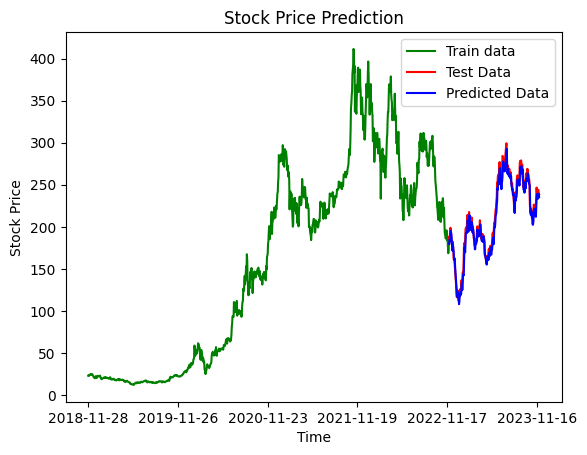

In [70]:
df.reset_index(inplace=True)
plt.plot(df.loc[:t_size+1,'Date'],df.loc[:t_size+1,'Open'], color='green',label="Train data")
plt.plot(df.loc[t_size:, 'Date'],data_test, color = 'red', label = 'Test Data')
plt.plot(df.loc[t_size:, 'Date'],predicted_price, color = 'blue', label = 'Predicted Data')
plt.xticks(np.arange(0,df.shape[0],250))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


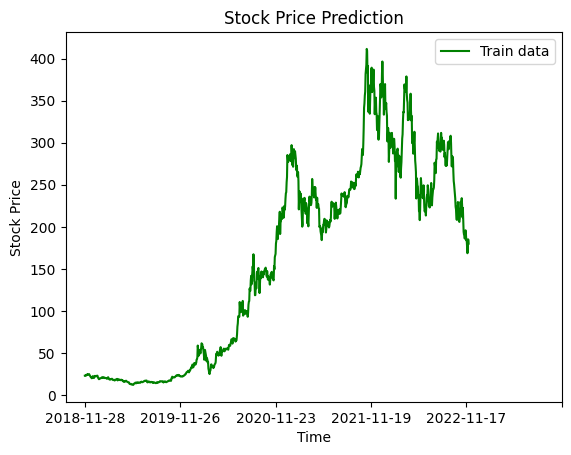

In [71]:
plt.plot(df.loc[:t_size+1,'Date'],df.loc[:t_size+1,'Open'], color='green',label="Train data")

plt.xticks(np.arange(0,df.shape[0],250))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

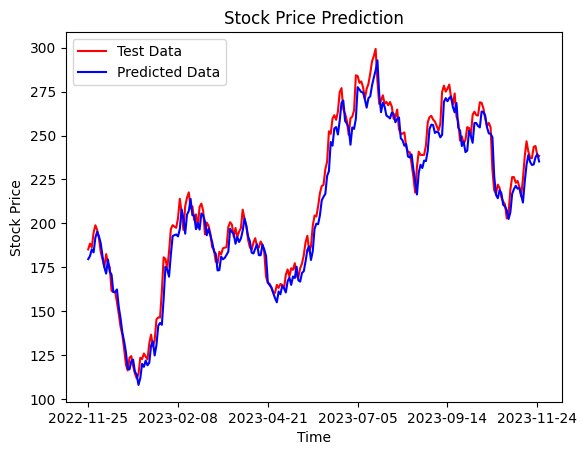

In [72]:
plt.plot(df.loc[t_size:, 'Date'],data_test, color = 'red', label = 'Test Data')
plt.plot(df.loc[t_size:, 'Date'],predicted_price, color = 'blue', label = 'Predicted Data')
plt.xticks(np.arange(0,x_test.shape[0],50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(data_test,predicted_price)

mse = mean_squared_error(data_test, predicted_price)

rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Mean Absolute Error (MAE): 6.25
Mean Squared Error (MSE): 62.71
Root Mean Squared Error (RMSE): 7.92


Predict Future

In [74]:
test2=data_test.copy()
for i in range(f_size):
  X=test2[-w_size:]
  X=X.reshape(w_size,1)
  X=sc.fit_transform(X)

  X=np.reshape(X,(1,w_size,1))

  close=algo.predict(X)
  y=sc.inverse_transform(close)

  test2=np.append(test2, y)


1/1 [==============================] - 0s 22ms/step


In [75]:
from datetime import datetime, timedelta
x=df.loc[-1:, 'Date']
day=x[len(x)-1]
date_obj = datetime.strptime(day, '%Y-%m-%d')
start_date = date_obj
date_list = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(f_size)]

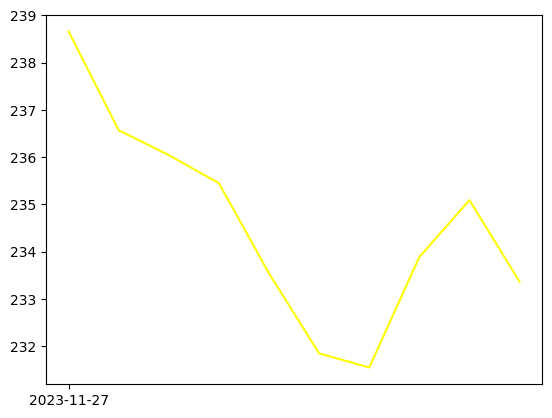

In [76]:
forcasted_data=test2[-f_size:]
plt.plot(date_list,forcasted_data,color='yellow', label="Future data")
plt.xticks(np.arange(0,len(forcasted_data),10))
plt.show()

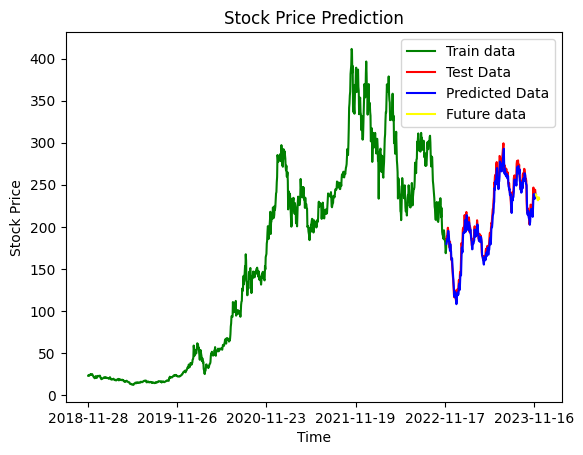

In [77]:

plt.plot(df.loc[:t_size,'Date'],df.loc[:t_size,'Open'], color='green',label="Train data")
plt.plot(df.loc[t_size:, 'Date'],data_test, color = 'red', label = 'Test Data')
plt.plot(df.loc[t_size:, 'Date'],predicted_price, color = 'blue', label = 'Predicted Data')
plt.plot(date_list,forcasted_data,color='yellow', label="Future data")
plt.xticks(np.arange(0,df.shape[0],250))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

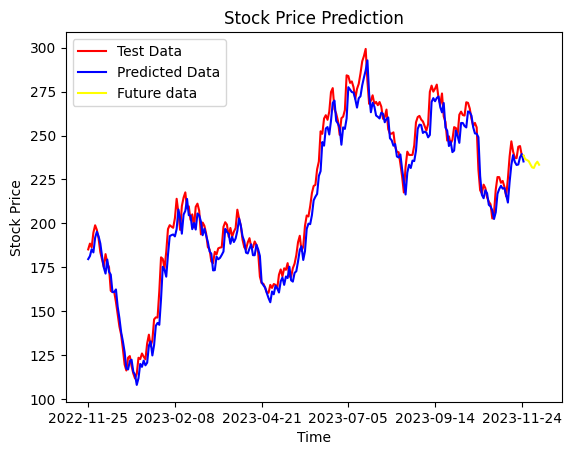

In [78]:
plt.plot(df.loc[t_size:, 'Date'],data_test, color = 'red', label = 'Test Data')
plt.plot(df.loc[t_size:, 'Date'],predicted_price, color = 'blue', label = 'Predicted Data')
plt.plot(date_list,forcasted_data,color='yellow', label="Future data")
plt.xticks(np.arange(0,x_test.shape[0],50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()